In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import string


In [2]:
df_train = pd.read_csv('data/train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('data/test.csv', dtype={'id': np.int16})

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.20 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.08 MB


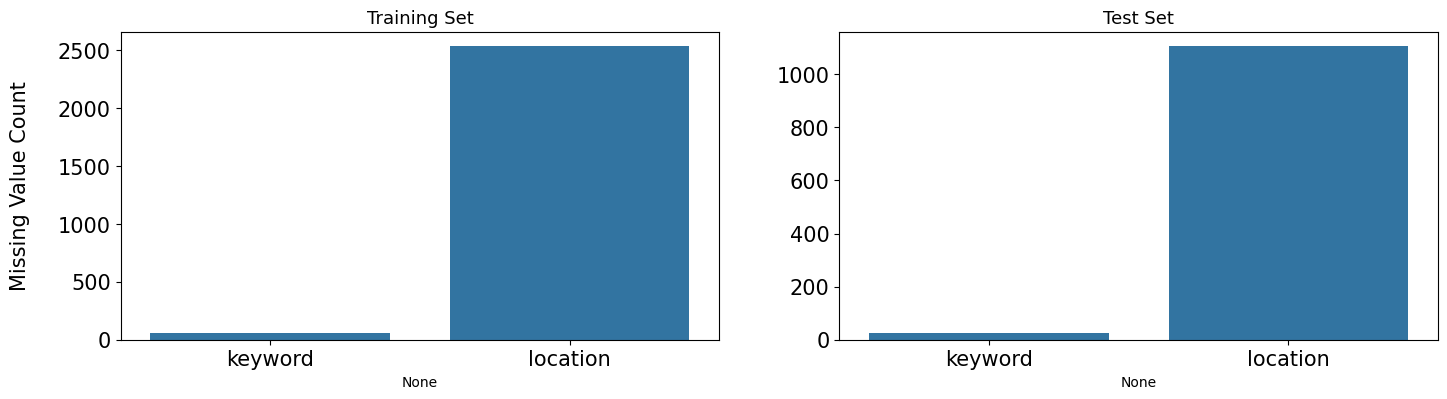

In [3]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x=df_train[missing_cols].isnull().sum().index, y=df_train[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=df_test[missing_cols].isnull().sum().index, y=df_test[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()

for df in [df_train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

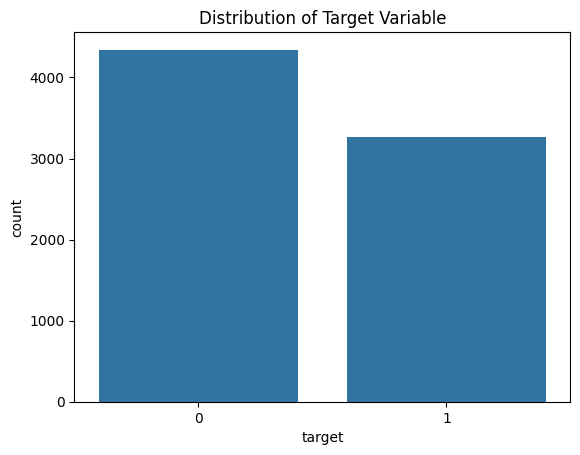

In [5]:
sns.countplot(x='target', data=df_train)
plt.title('Distribution of Target Variable')
plt.show()

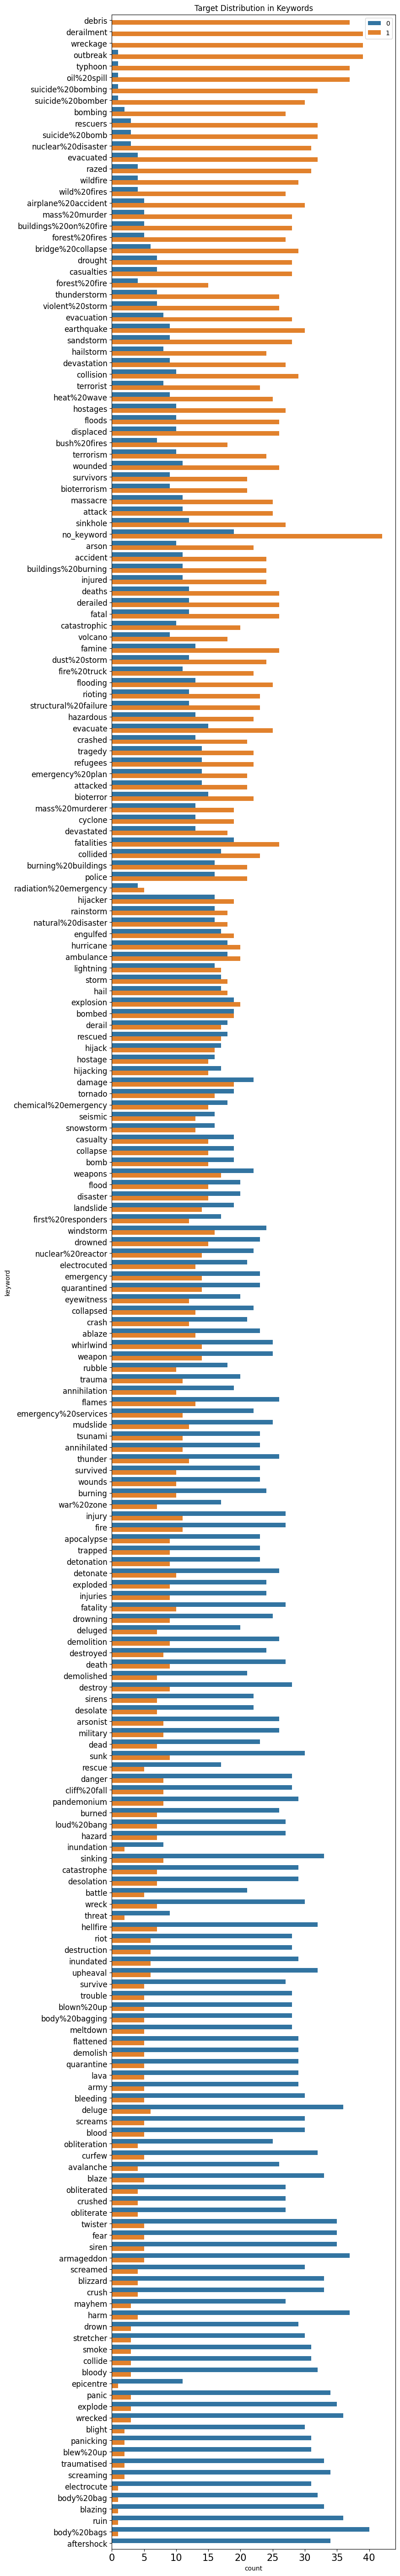

In [4]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

In [6]:
# Top keywords and their count
print(df_train['keyword'].value_counts().head(10))

# Check if there's a significant difference in disaster tweets vs. non-disaster tweets for the top keywords
pd.crosstab(df_train['keyword'], df_train['target']).sort_values(1, ascending=False).head(10)

# Locations might be too varied and less clean, but let's check the top ones
print(df_train['location'].value_counts().head(10))


keyword
no_keyword     61
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
evacuate       40
fear           40
Name: count, dtype: int64
location
no_location        2533
USA                 104
New York             71
United States        50
London               45
Canada               29
Nigeria              28
UK                   27
Los Angeles, CA      26
India                24
Name: count, dtype: int64


count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: text_len, dtype: float64


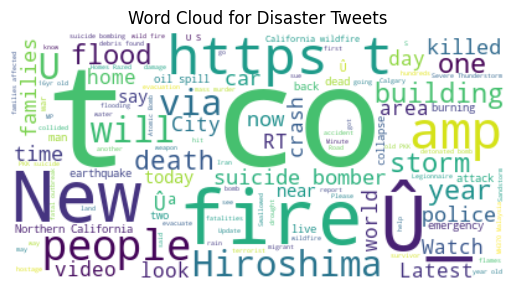

In [10]:
df_train['text_len'] = df_train['text'].apply(lambda x: len(x))
print(df_train['text_len'].describe())

disaster_tweets = ' '.join(text for text in df_train[df_train['target'] == 1]['text'])
wordcloud = WordCloud(background_color='white').generate(disaster_tweets)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Disaster Tweets')
plt.show()


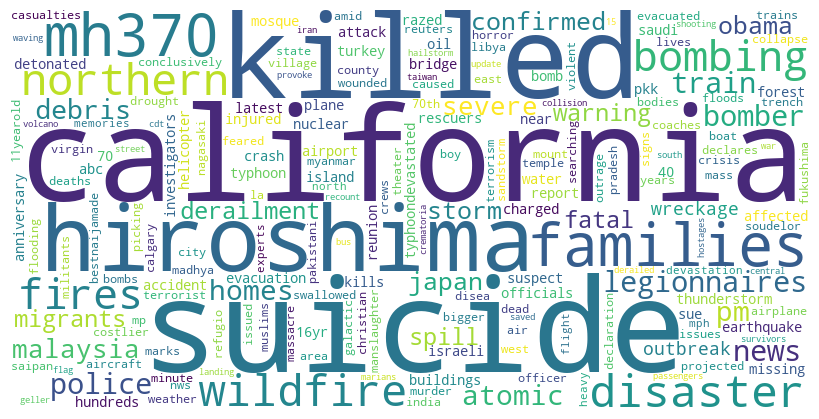

In [14]:
disaster_tweets = df_train[df_train['target'] == 1]['text']
non_disaster_tweets = df_train[df_train['target'] == 0]['text']

def clean_text(text):
    text = "".join([char for char in text if char not in string.punctuation])
    text = text.lower()
    return text

disaster_tweets_clean = disaster_tweets.apply(clean_text)
non_disaster_tweets_clean = non_disaster_tweets.apply(clean_text)

vectorizer = CountVectorizer(stop_words='english')

disaster_counts = vectorizer.fit_transform(disaster_tweets_clean)
disaster_freq = np.ravel(disaster_counts.sum(axis=0))

non_disaster_counts = vectorizer.transform(non_disaster_tweets_clean)
non_disaster_freq = np.ravel(non_disaster_counts.sum(axis=0))

vocab = vectorizer.get_feature_names_out()
freq_df = pd.DataFrame({'word': vocab, 'disaster': disaster_freq, 'non_disaster': non_disaster_freq})
freq_df['disaster_freq'] = freq_df['disaster'] / freq_df['disaster'].sum()
freq_df['non_disaster_freq'] = freq_df['non_disaster'] / freq_df['non_disaster'].sum()

freq_df['freq_diff'] = freq_df['disaster_freq'] - freq_df['non_disaster_freq']

disaster_specific_words = freq_df[freq_df['freq_diff'] > 0].sort_values(by='freq_diff', ascending=False)

word_freq_dict = disaster_specific_words.set_index('word')['freq_diff'].to_dict()

wordcloud = WordCloud(width = 800, height = 400, background_color ='white')

wordcloud.generate_from_frequencies(word_freq_dict)
                     
plt.figure(figsize = (8, 8), edgecolor = 'k') 
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.tight_layout(pad = 0) 

plt.show()


In [17]:
STOPWORDS = {'the', 'a', 'and', 'is', 'in', 'it', 'of', 'to', 'you'}

def compute_text_features(df):
    # You can directly compute all the features within this function
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
    df['unique_word_count'] = df['text'].apply(lambda x: len(set(str(x).split())))
    df['stop_word_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    df['url_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
    df['mean_word_length'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    df['char_count'] = df['text'].str.len()
    df['punctuation_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    df['hashtag_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
    df['mention_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
    return df

df_train = compute_text_features(df_train)
df_test = compute_text_features(df_test)

C:\Users\elian\AppData\Local\Temp\ipykernel_34348\3272337386.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
C:\Users\elian\AppData\Local\Temp\ipykernel_34348\3272337386.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750b

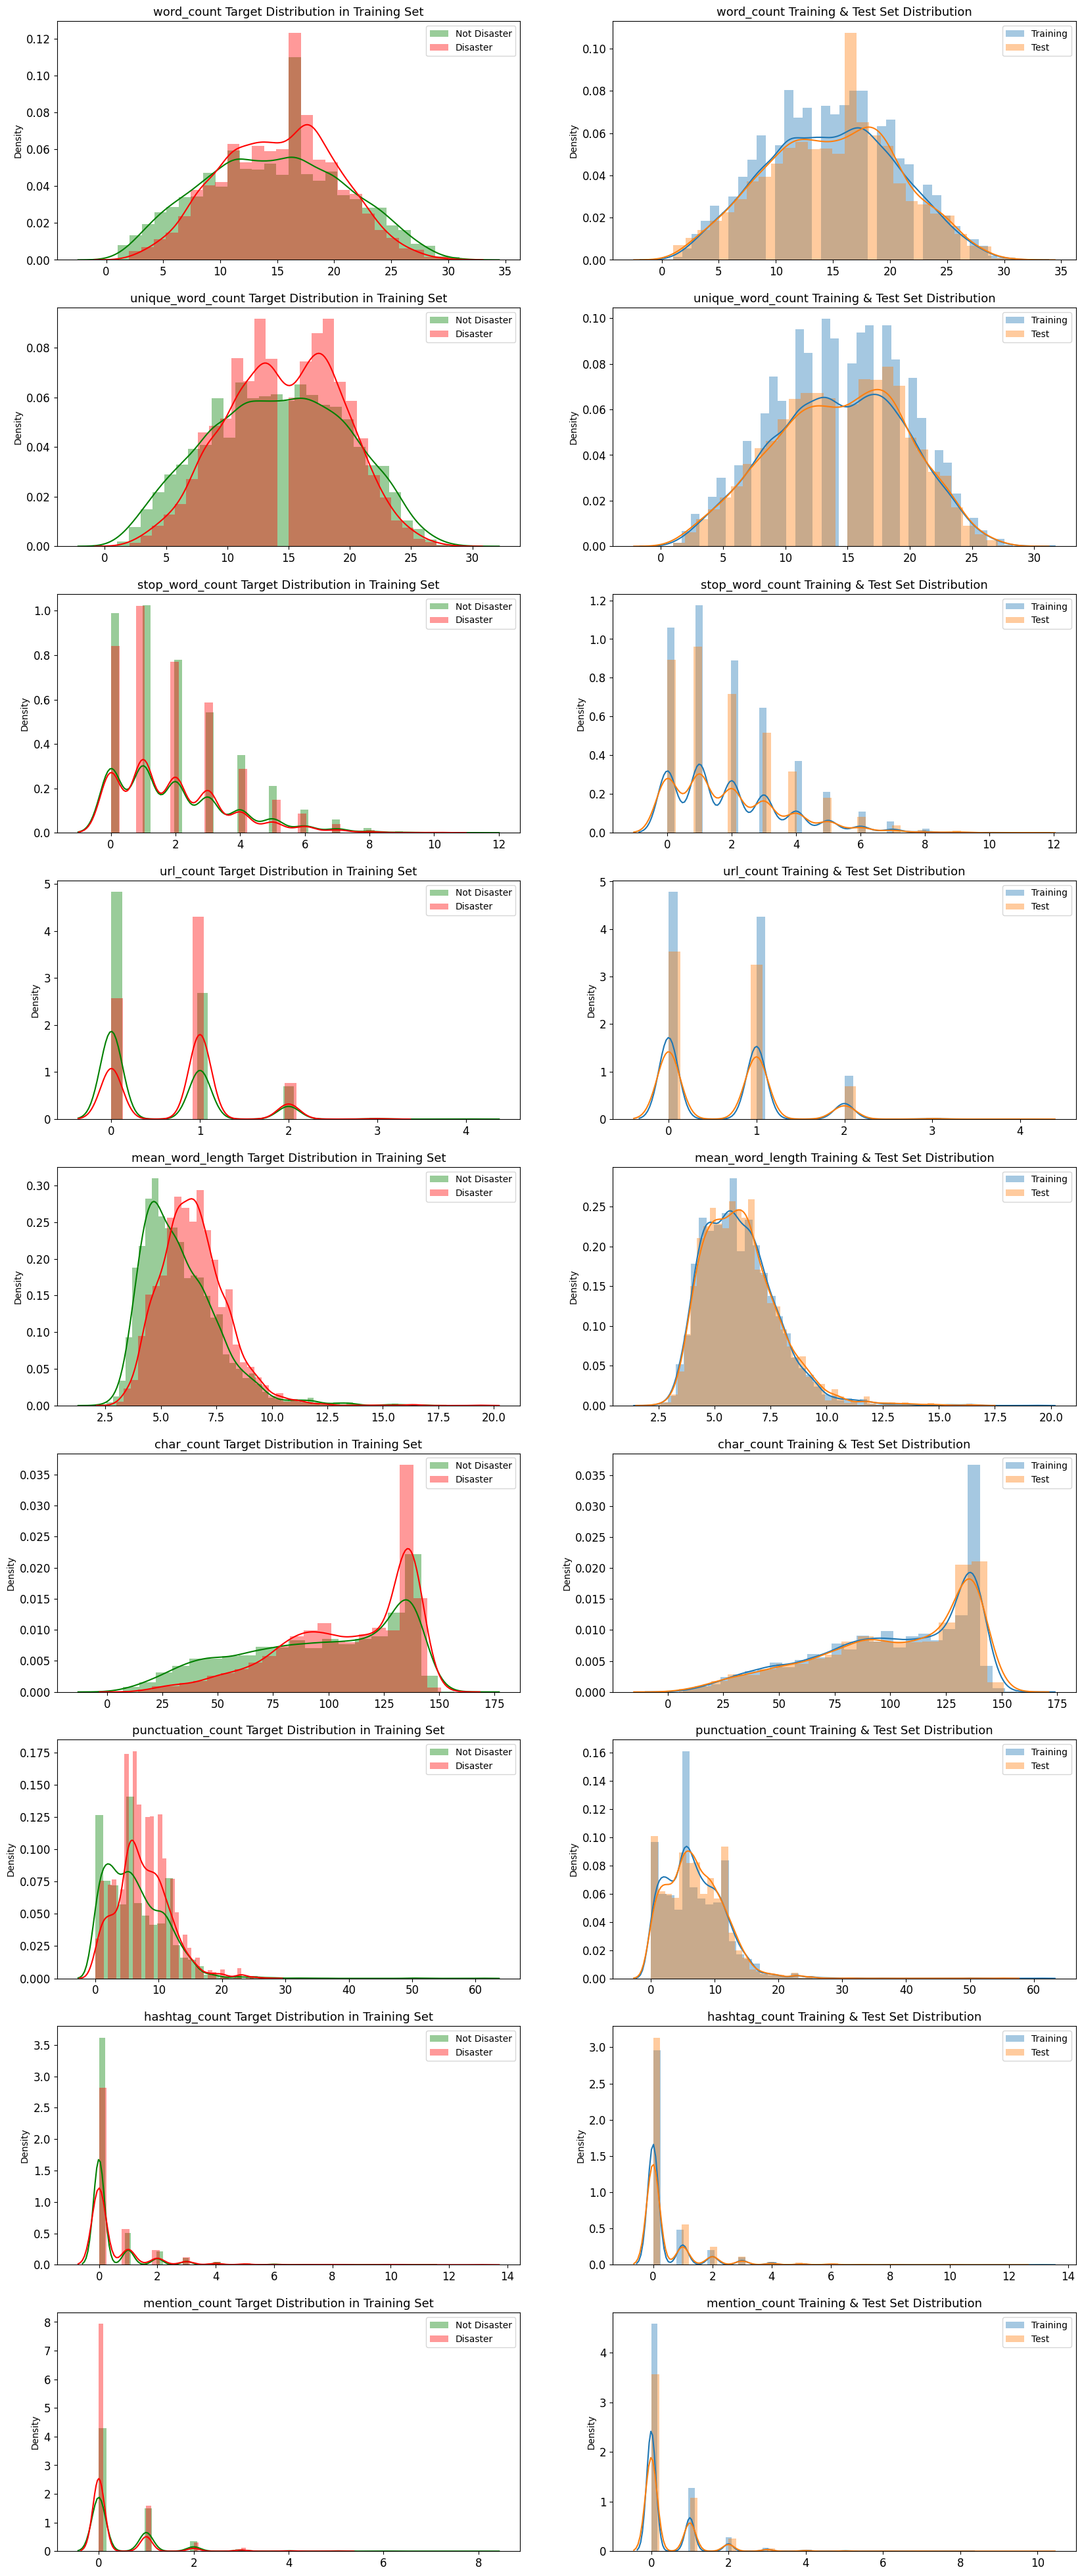

In [18]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(df_train[feature], label='Training', ax=axes[i][1])
    sns.distplot(df_test[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()